# Predicting Youth Marijuana Usage: Has the Youth Ever Used Marijuana?

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

### Data Loading and Cleaning

In [32]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

df = pd.read_csv('youth_data.csv')

#Replace true missing codes (994, 997, 998) with NaN to standardize missingness

columns_with_991_993 = ['IRALCFY', 'IRMJFY', 'IRCIGFM', 
                        'IRSMKLSS30N', 'IRMJFM', 'IRCIGAGE', 
                        'IRSMKLSSTRY', 'IRALCAGE']

for col in columns_with_991_993:
    if col in df.columns:
        df[col] = df[col].replace({994: np.nan, 997: np.nan, 998: np.nan})
        

        df[col] = df[col].replace({991: np.nan, 993: np.nan})

#For past-month frequency variables, map 91 (Never Used) and 93 (Did Not Use Last Month) to 0
columns_with_91_93 = ['IRCIGFM', 'IRSMKLSS30N', 'IRMJFM']
for col in columns_with_91_93:
    if col in df.columns:
        df[col] = df[col].replace({91: 0, 93: 0})

#Replace invalid school absence codes (94, 97, 98, 99) with NaN to treat as missing data
if 'EDUSKPCOM' in df.columns:
    df['EDUSKPCOM'] = df['EDUSKPCOM'].replace({94: np.nan, 97: np.nan, 98: np.nan, 99: np.nan})

# Map parental presence (IMOTHER, IFATHER) to binary: 1 = Present, 0 = Absent
if 'IMOTHER' in df.columns:
    df = df[df['IMOTHER'] != 4] 
    df['IMOTHER'] = df['IMOTHER'].map({1: 1, 2: 0, 3: np.nan})

if 'IFATHER' in df.columns:
    df = df[df['IFATHER'] != 4]
    df['IFATHER'] = df['IFATHER'].map({1: 1, 2: 0, 3: np.nan})

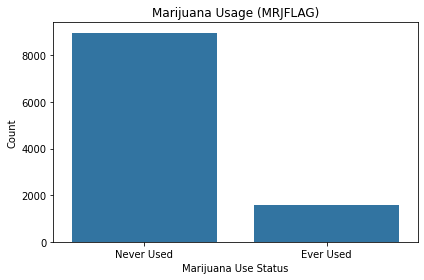

In [40]:
sns.countplot(x='MRJFLAG', data=df)

plt.title('Marijuana Usage (MRJFLAG)')
plt.xlabel('Marijuana Use Status')
plt.ylabel('Count')

# Custom tick labels for 0 and 1
plt.xticks(ticks=[0, 1], labels=['Never Used', 'Ever Used'])

plt.tight_layout()
plt.savefig("MRJFLAG_labeled_plot.png", dpi=300, bbox_inches='tight')
plt.show()

### Feature Engineering

In [31]:
#Defined features based on demographic, school and Parental
demographic_features = ['IRSEX', 'NEWRACE2', 'INCOME', 'POVERTY3', 'PDEN10', 'COUTYP4', 'HEALTH2']
school_features = ['EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM']
parental_features = ['IMOTHER', 'IFATHER', 'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 
                     'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'ARGUPAR']

all_features = demographic_features + school_features + parental_features
target = 'MRJFLAG'

df_clean = df.dropna(subset=all_features + [target])

#Impute missing values with mean to preserve sample size
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(df_clean[all_features]), columns=all_features)
y = df_clean[target]

print("Final dataset shape:", X.shape)

Final dataset shape: (7397, 20)


### Decision Tree Classifier (Unpruned)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (5177, 20)
Test set size: (2220, 20)


In [16]:
feature_map = {
    'IRSEX': 'Gender',
    'NEWRACE2': 'Race/Ethnicity',
    'INCOME': 'Family Income',
    'POVERTY3': 'Poverty Level',
    'PDEN10': 'Population Density',
    'COUTYP4': 'County Type',
    'HEALTH2': 'Health Rating',
    'EDUSCHLGO': 'Currently in School',
    'EDUSCHGRD2': 'School Grade',
    'EDUSKPCOM': 'Missed School Days (Sick)',
    'IMOTHER': 'Mother in Household',
    'IFATHER': 'Father in Household',
    'PARCHKHW': 'Parent Checks Homework',
    'PARHLPHW': 'Parent Helps Homework',
    'PRCHORE2': 'Parent Assigns Chores',
    'PRLMTTV2': 'Limits on TV Time',
    'PARLMTSN': 'Limits on Going Out',
    'PRGDJOB2': 'Parental Praise (Job)',
    'PRPROUD2': 'Parental Pride',
    'ARGUPAR': 'Family Arguments'
}

# Rename columns for X_train and X_test to make it easy for reading
X_train.rename(columns=feature_map, inplace=True)
X_test.rename(columns=feature_map, inplace=True)

Unpruned Decision Tree Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1896
           1       0.23      0.26      0.24       324

    accuracy                           0.77      2220
   macro avg       0.55      0.56      0.55      2220
weighted avg       0.78      0.77      0.77      2220



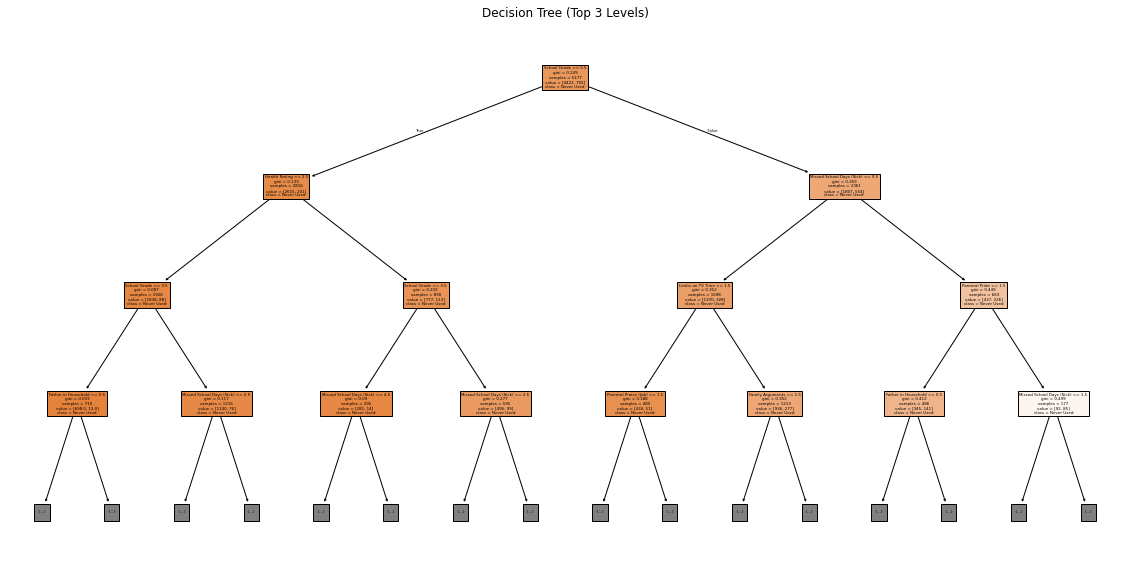

|--- School Grade <= 5.50
|   |--- Health Rating <= 2.50
|   |   |--- School Grade <= 3.50
|   |   |   |--- Father in Household <= 0.50
|   |   |   |   |--- Parent Checks Homework <= 1.50
|   |   |   |   |   |--- Gender <= 1.50
|   |   |   |   |   |   |--- Population Density <= 2.50
|   |   |   |   |   |   |   |--- Health Rating <= 1.50
|   |   |   |   |   |   |   |   |--- Limits on TV Time <= 1.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Limits on TV Time >  1.50
|   |   |   |   |   |   |   |   |   |--- Mother in Household <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- Race/Ethnicity <= 3.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- Race/Ethnicity >  3.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- Mother in Household >  0.50
|   |   |   |   |   |   |   |   |   |   |--- Race/Ethnicity <= 4.00
|   |   |   |   |   |   |  

In [17]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = tree_model.predict(X_test)

# Evaluate
print("Unpruned Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# View of tree depth=3
plt.figure(figsize=(20,10))
plot_tree(tree_model, feature_names=X_train.columns, 
          class_names=['Never Used', 'Ever Used'], 
          filled=True, max_depth=3)
plt.title('Decision Tree (Top 3 Levels)')
plt.show()

# Printing only first 1500 
tree_summary = export_text(tree_model, feature_names=list(X_train.columns))
print(tree_summary[:1500])  


                 feature_name  importance
0                School Grade    0.113057
1              Race/Ethnicity    0.096866
2   Missed School Days (Sick)    0.081602
3               Family Income    0.067468
4                 County Type    0.065660
5                      Gender    0.062296
6         Limits on Going Out    0.060863
7               Health Rating    0.059774
8          Population Density    0.053879
9               Poverty Level    0.050188
10      Parent Helps Homework    0.038996
11      Parent Assigns Chores    0.037484
12        Father in Household    0.035019
13     Parent Checks Homework    0.034181
14        Mother in Household    0.030196
15             Parental Pride    0.028989
16          Limits on TV Time    0.028987
17      Parental Praise (Job)    0.028505
18           Family Arguments    0.025990
19        Currently in School    0.000000


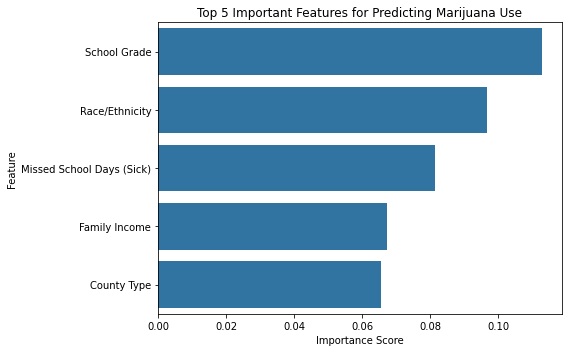

In [24]:
#Importances of given predictors in the above tree
importances = pd.DataFrame({'feature_name': X_train.columns, 'importance': tree_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(importances)

importances = pd.Series(tree_model.feature_importances_, index=X_train.columns)

# Sort for Top 5
top5_importances = importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top5_importances.values, y=top5_importances.index)
plt.title('Top 5 Important Features for Predicting Marijuana Use')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Pruning Decision Tree

Pruned Decision Tree Accuracy: 0.8540540540540541
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1896
           1       0.00      0.00      0.00       324

    accuracy                           0.85      2220
   macro avg       0.43      0.50      0.46      2220
weighted avg       0.73      0.85      0.79      2220



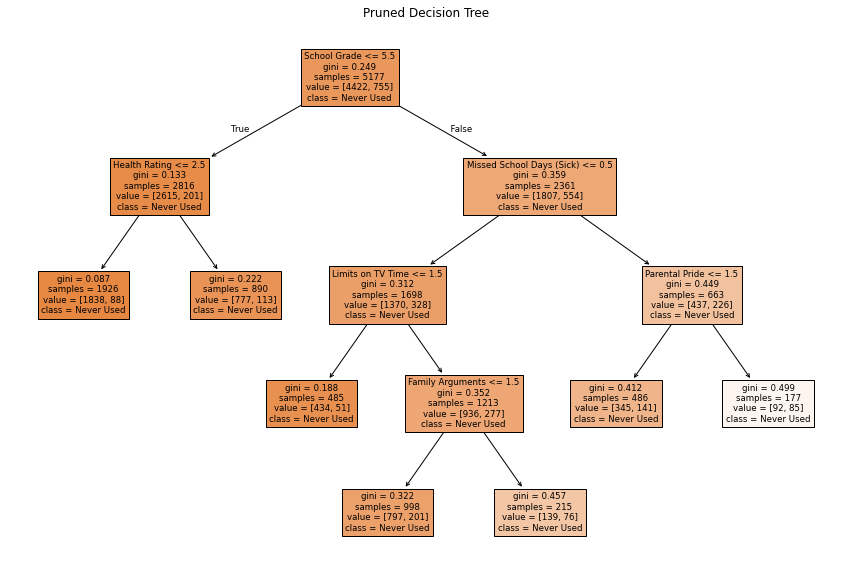

Best Tree Size (max_leaf_nodes): 7


In [25]:
# Tuning tree size using cross-validation
param_grid = {'max_leaf_nodes': range(2, 20)}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                              param_grid=param_grid, 
                              cv=5, scoring='accuracy')

grid_search_dt.fit(X_train, y_train)

pruned_tree = grid_search_dt.best_estimator_

y_pred_pruned = pruned_tree.predict(X_test)

# Evaluate
print("Pruned Decision Tree Accuracy:", accuracy_score(y_test, y_pred_pruned))
print(classification_report(y_test, y_pred_pruned))

# Plot pruned tree
plt.figure(figsize=(15,10))
plot_tree(pruned_tree, feature_names=X_train.columns, 
          class_names=['Never Used', 'Ever Used'], 
          filled=True)
plt.title('Pruned Decision Tree')
plt.show()

print(f"Best Tree Size (max_leaf_nodes): {grid_search_dt.best_params_['max_leaf_nodes']}")

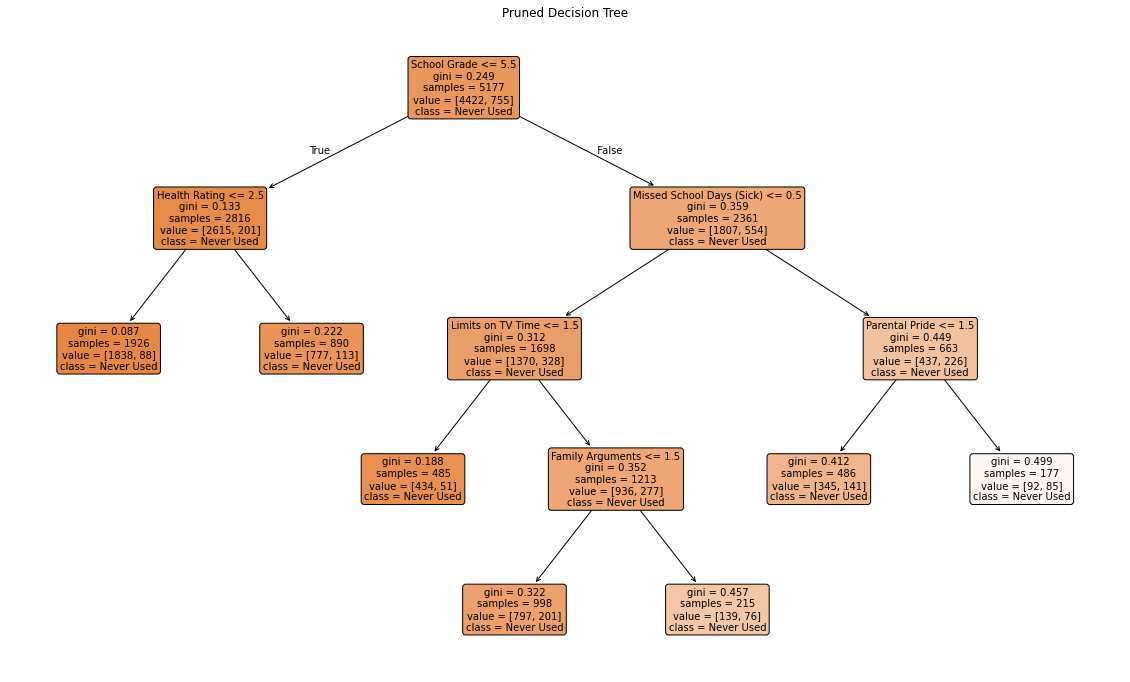

In [37]:
plt.figure(figsize=(20, 12)) 
plot_tree(
    pruned_tree,
    feature_names=X_train.columns,
    class_names=['Never Used', 'Ever Used'],
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title('Pruned Decision Tree')
plt.savefig('Pruned_Decision_Tree_HighRes.png', dpi=600, bbox_inches='tight')
plt.show()

### Random Forest

Random Forest Accuracy: 0.836036036036036
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1896
           1       0.28      0.08      0.12       324

    accuracy                           0.84      2220
   macro avg       0.57      0.52      0.52      2220
weighted avg       0.78      0.84      0.80      2220



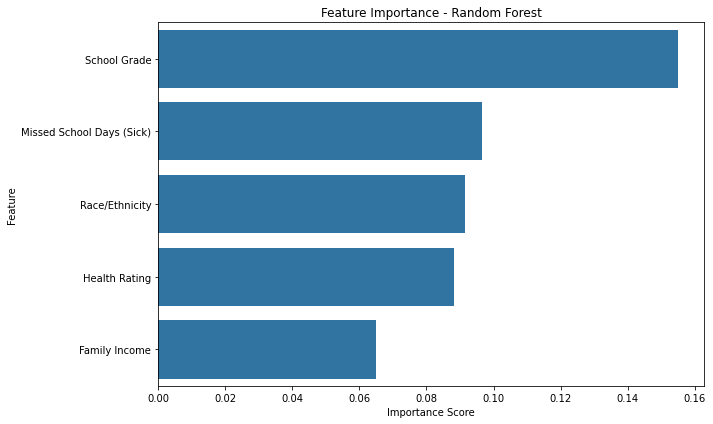

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top5_importances = importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(x=top5_importances, y=top5_importances.index)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [29]:
print("Summary of Model Accuracies:")
print(f"- Unpruned Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"- Pruned Decision Tree Accuracy: {accuracy_score(y_test, y_pred_pruned):.4f}")
print(f"- Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

if accuracy_score(y_test, y_pred_rf) > accuracy_score(y_test, y_pred_pruned):
    print("\nRandom Forest outperformed both Decision Tree versions.")
else:
    print("\nPruned Decision Tree performed competitively with Random Forest.")


Summary of Model Accuracies:
- Unpruned Decision Tree Accuracy: 0.7667
- Pruned Decision Tree Accuracy: 0.8541
- Random Forest Accuracy: 0.8360

Pruned Decision Tree performed competitively with Random Forest.


### Random Forest with class balanced

Random Forest Accuracy: 0.836036036036036
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1896
           1       0.28      0.08      0.12       324

    accuracy                           0.84      2220
   macro avg       0.57      0.52      0.52      2220
weighted avg       0.78      0.84      0.80      2220



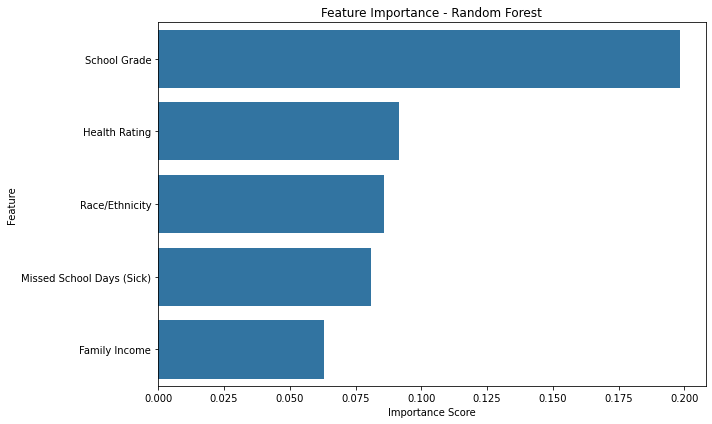

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model_b = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model_b.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Feature Importance
importances = pd.Series(rf_model_b.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top5_importances = importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(x=top5_importances, y=top5_importances.index)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Conclusion

- Decision Trees and Random Forests achieved high overall accuracy, but minority class prediction (Ever Used Marijuana) remains challenging.
- Random Forests slightly improved minority detection but recall remains low.
- Future work could include SMOTE oversampling, deeper hyperparameter tuning, or trying different ensemble methods to further improve recall and fairness.
